In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r '/content/drive/MyDrive/colab_projects/Computational_Drug_Discovery' '/content'

We use chemble dataset as our resource in order to analyze the drug candidates of corona virus.

In [3]:
!pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import sys
from chembl_webresource_client.new_client import new_client
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor

We use the target attribute of new_client object in order to access the corona virus information and then convert it to a dataframe.
The targets here are listed as "organsim" or "single protein" which means the activity data pertains to the whole organism or a single protein of it. This suggests that the drug might be targeting the virus as a whole (or its broad biological functions), rather or a specific protein within the virus.

In case you want to directly access the ChEMBL website use the following code:

In [ ]:
# target_query = new_client.target.search('coronavirus')
# targets = pd.DataFrame.from_dict(target_query)
# targets.head(3)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.00,False,CHEMBL613732,[],ORGANISM,11119
1,[],Feline coronavirus,Feline coronavirus,14.00,False,CHEMBL612744,[],ORGANISM,12663
2,[],Murine coronavirus,Murine coronavirus,14.00,False,CHEMBL5209664,[],ORGANISM,694005


In [6]:
targets = pd.read_csv('/content/drive/MyDrive/colab_projects/Computational_Drug_Discovery/acetylcholinesterase_01_bioactivity_data_raw.csv')

In [7]:
targets.shape

(7026, 43)

In [9]:
targets.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00


In this code, we'd like to do some experiment on those components which target a single protien. Since the database comprises of different target types such as: single protein, tissue-based and so on, we filter out those which are not single protein. Here, the single protein target type is specified as 'CHEMBL220' ID in the dataframe.

In [8]:
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL220'

We use the activity attribute of new client object in order to get information on the biological activity. Here, we filter out the data based on our specific target (single protein in this case) and select IC50 as an indicator of how likely we can lower the effect of the virus to 50% if we use a certain amount of drug.

In [193]:
activity = new_client.activity
res = activity.filter(target_chembl_id = selected_target).filter(standard_type = "IC50")

In [230]:
df_activity = pd.DataFrame.from_dict(res)
df_activity.head(3)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0


In [231]:
df_activity.shape

(9415, 46)

In [232]:
df_activity.to_csv('/content/bioactivity_data.csv', index = False)

# Preprocessing

We check if there are any missing values in the standard_value column.

<Axes: >

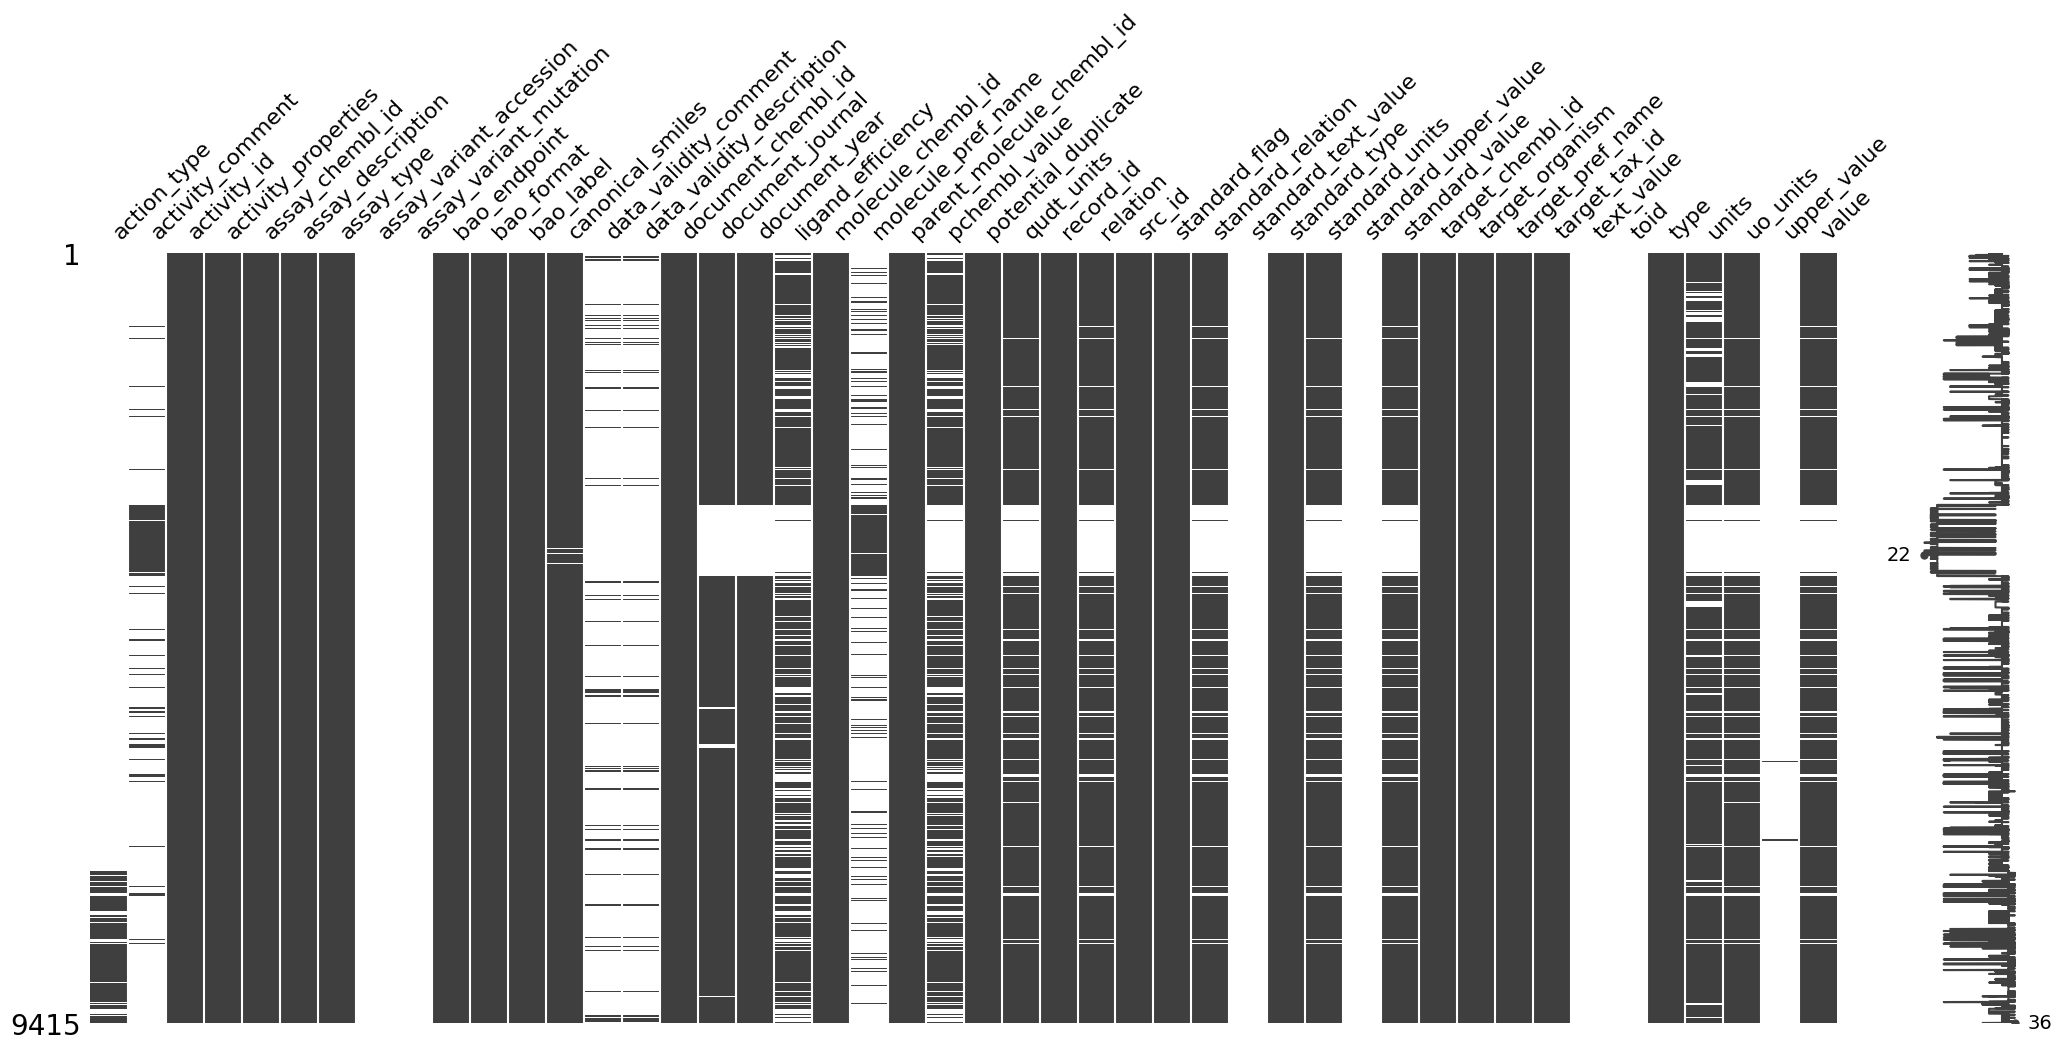

In [233]:
msno.matrix(df_activity)

In [234]:
df_activity.isnull().sum()

,0
action_type,7893
activity_comment,8074
activity_id,0
activity_properties,0
assay_chembl_id,0
assay_description,0
assay_type,0
assay_variant_accession,9415
assay_variant_mutation,9415
bao_endpoint,0


In [235]:
df_preprocessed = df_activity.loc[~df_activity['canonical_smiles'].isnull()]

In [236]:
df_preprocessed = df_preprocessed.loc[~df_preprocessed['standard_value'].isnull() & (df_preprocessed['standard_value'] != 0)]

In [237]:
df_preprocessed.shape

(8128, 46)

In [238]:
df_preprocessed.isna().sum()

,0
action_type,6607
activity_comment,8065
activity_id,0
activity_properties,0
assay_chembl_id,0
assay_description,0
assay_type,0
assay_variant_accession,8128
assay_variant_mutation,8128
bao_endpoint,0


The concept of bioactivity refers to how biologically active a compound is, or how likely it is to cause effect on a biological system.
We classify the bioactivity of the compounds in such categories:
- Active: The compound is highly potent or effective at lower concentrations (e.g., IC50 ≤ 1000 nM).
- Inactive: The compound is much less potent or ineffective at higher concentrations (e.g., IC50 ≥ 10,000 nM).
- Intermediate: The compound’s potency falls between the active and inactive thresholds.

In [239]:
def classify_bioactivity(value):
    if float(value) <= 1000:
        return 'active'
    elif float(value) >= 10000:
        return 'inactive'
    else:
        return 'intermediate'

In [240]:
bioactivity_class = df_preprocessed['standard_value'].apply(classify_bioactivity)

In [241]:
bioactivity_class

,standard_value
0,active
1,active
2,inactive
3,active
4,active
...,...
9410,inactive
9411,inactive
9412,intermediate
9413,inactive


We would like to create a dataframe to store important features such as:
- Molecular ID
- SMILES which is a shorthand way to encode the molecular structure of compounds. For instance: Water => O, Ethanol => CCO
- Standard Value
- Bioactivity

In [242]:
mol_cid = []
for i in df_preprocessed.molecule_chembl_id:
  mol_cid.append(i)

In [243]:
canonical_smiles = []
for i in df_preprocessed.canonical_smiles:
  canonical_smiles.append(i)

In [244]:
standard_value = []
for i in df_preprocessed.standard_value:
  standard_value.append(i)

In [245]:
data_tuples = list(zip(mol_cid, canonical_smiles, bioactivity_class, standard_value))
df_preprocessed = pd.DataFrame(data_tuples, columns = ['molecule_chembl_id', 'canonical_smiles', 'bioactivity_class', 'standard_value'])

In [246]:
df_preprocessed

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,800.0
...,...,...,...,...
8123,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,46000.0
8124,CHEMBL11298,N[C@@H](CO)C(=O)O,inactive,38310.0
8125,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,intermediate,1710.0
8126,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,10000.0


In [247]:
df_preprocessed.to_csv('/content/bioactivity_preprocessed_data.csv', index = False)

RDKit is an open-source cheminformatics software toolkit that provides a wide array of tools for working with chemical informatics data. Here we use RDKit to calculate molecular descriptors based on SMILES strings.

In [248]:
! pip install rdkit

In drug discovery and molecular modeling, Lipinski's Rule of Five is used to estimate "drug-likeness" of a compound. It uses the following molecular descriptors:

* Molecular Weight (MW): Helps predict whether a compound is likely to be absorbed into the bloodstream. Compounds that are too large may not be able to cross cell membranes efficiently.

* LogP: Determines whether the compound is hydrophobic or hydrophilic. A LogP value that’s too high or too low may make the compound difficult to absorb or metabolize.

* Hydrogen Bond Donors/Acceptors: These properties influence how well a compound can interact with biological targets (e.g., receptors, enzymes), affecting its bioactivity.

In [249]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [250]:
def lipinski(smiles, verbose=False):

    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i == 0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)

    return descriptors

We apply the rdkit function on our preprocessed data to extract molecular descriptors. We then concat the two dataframes with each other to create a new dataframe.

In [251]:
df_lipinski = lipinski(df_preprocessed.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
8123,301.298,2.0110,4.0,6.0
8124,105.093,-1.6094,3.0,3.0
8125,401.474,2.9571,3.0,5.0
8126,387.447,2.6149,4.0,5.0


In [252]:
df_combined = pd.concat([df_preprocessed, df_lipinski], axis = 1)
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,750.0,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,100.0,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,50000.0,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,300.0,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,800.0,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
8123,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,46000.0,301.298,2.0110,4.0,6.0
8124,CHEMBL11298,N[C@@H](CO)C(=O)O,inactive,38310.0,105.093,-1.6094,3.0,3.0
8125,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,intermediate,1710.0,401.474,2.9571,3.0,5.0
8126,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,10000.0,387.447,2.6149,4.0,5.0


# Preprocessing 2

Since the standard value is in nano-molar, we would like to convert it to a scale which is more convenient to work with. pIC50 is the negative logarithm (base 10) of the IC50 value, but expressed in molar units (M).

If the IC50 is extremely large (like > 100,000,000 nM), its pIC50 value would be negative or extremely low, which would be hard to interpret or lead to outliers; so we make sure to consider that as well.

In [253]:
# def norm_value(input):
#     norm = []

#     for i in input['standard_value'].astype(float):
#         if i > 100000000:
#           i = 100000000
#         norm.append(i)

#     input['standard_value_norm'] = norm
#     x = input.drop('standard_value', axis = 1)

#     return x

In [254]:
# df_norm = norm_value(df_combined)
# df_norm

In [261]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        molar = float(i) * (10**-9) # Converts nM to M
        molar = np.where(molar == 0, 1e-10, molar)  # Replace 0 with 1e-10
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', axis=1)

    return x

In [262]:
df_preprocessed2 = pIC50(df_combined)
df_preprocessed2

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
8123,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,301.298,2.0110,4.0,6.0,4.337242
8124,CHEMBL11298,N[C@@H](CO)C(=O)O,inactive,105.093,-1.6094,3.0,3.0,4.416688
8125,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,intermediate,401.474,2.9571,3.0,5.0,5.767004
8126,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,387.447,2.6149,4.0,5.0,5.000000


Since we mainly intend to focus on the difference between the active and inactive drug states, we omit those with the intermediate state.

In [263]:
df_preprocessed2 = df_preprocessed2[df_preprocessed2['bioactivity_class'] != 'intermediate']

In [264]:
df_preprocessed2['bioactivity_class'].unique()

array(['active', 'inactive'], dtype=object)

In [265]:
def handle_outliers(df, column, method="remove"):

    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if method == "remove":
        df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    elif method == "cap":
        df_filtered = df.copy()
        df_filtered[column] = np.clip(df[column], lower_bound, upper_bound)
    else:
        raise ValueError("Invalid method. Choose 'remove' or 'cap'.")

    return df_filtered

In [266]:
df_preprocessed2 = handle_outliers(df_preprocessed2, "LogP", method="remove")  # Removing outliers in LogP

In [282]:
df_preprocessed2 = handle_outliers(df_preprocessed2, "MW", method="cap")  # Capping outliers in MW

# Exploratory Data Analysis (EDA)

Text(0, 0.5, 'Frequency')

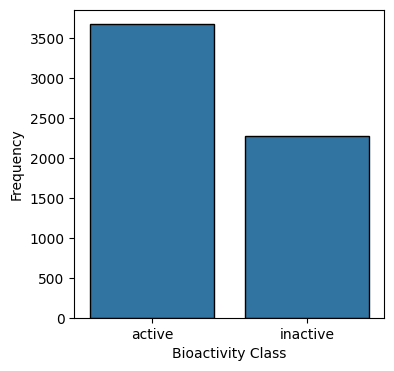

In [283]:
plt.figure(figsize = (4, 4))
sns.countplot(x='bioactivity_class', data=df_preprocessed2, edgecolor='black')
plt.xlabel('Bioactivity Class', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

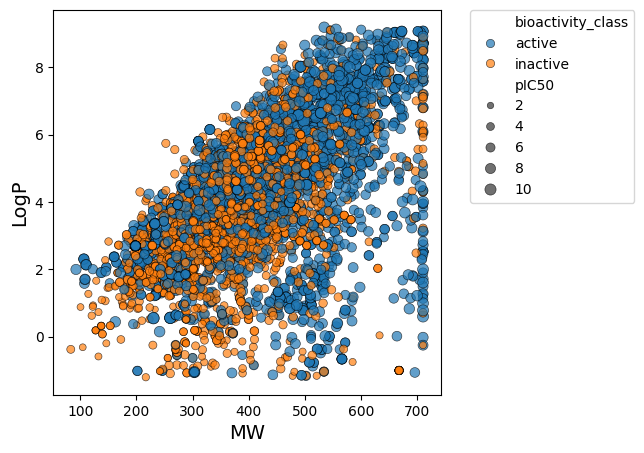

In [284]:
plt.figure(figsize=(5, 5))

sns.scatterplot(x='MW', y='LogP', data=df_preprocessed2, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14)
plt.ylabel('LogP', fontsize=14)
plt.legend(bbox_to_anchor=(1.5, 1), borderaxespad=0)

Text(0, 0.5, 'pIC50')

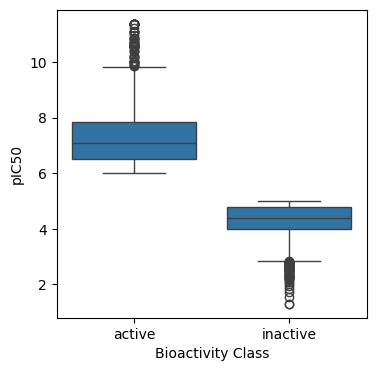

In [287]:
plt.figure(figsize = (4, 4))
sns.boxplot(x='bioactivity_class', y='pIC50', data=df_preprocessed2)
plt.xlabel('Bioactivity Class', fontsize=10)
plt.ylabel('pIC50', fontsize=10)

Text(0, 0.5, 'Molecular Weight')

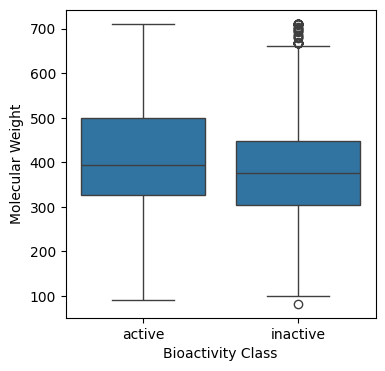

In [271]:
plt.figure(figsize = (4, 4))
sns.boxplot(x='bioactivity_class', y='MW', data=df_preprocessed2)
plt.xlabel('Bioactivity Class', fontsize=10)
plt.ylabel('Molecular Weight', fontsize=10)

Text(0, 0.5, 'LogP')

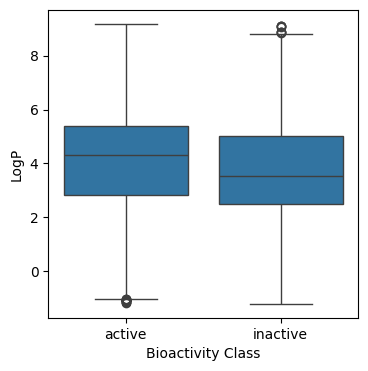

In [272]:
plt.figure(figsize = (4, 4))
sns.boxplot(x='bioactivity_class', y='LogP', data=df_preprocessed2)
plt.xlabel('Bioactivity Class', fontsize=10)
plt.ylabel('LogP', fontsize=10)

Text(0, 0.5, 'NumHDoners')

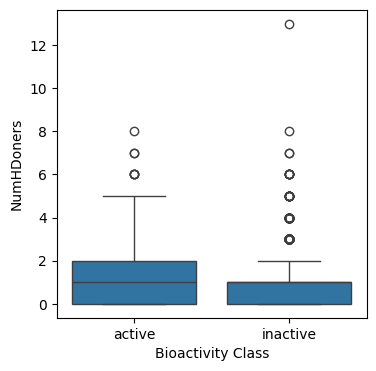

In [273]:
plt.figure(figsize = (4, 4))
sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_preprocessed2)
plt.xlabel('Bioactivity Class', fontsize=10)
plt.ylabel('NumHDoners', fontsize=10)

Text(0, 0.5, 'NumHAcceptors')

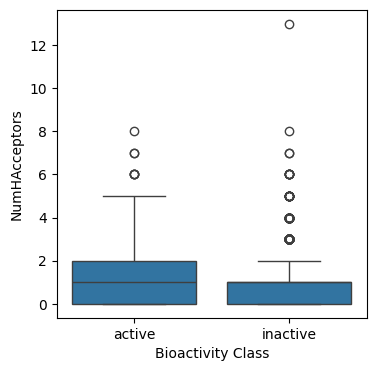

In [274]:
plt.figure(figsize = (4, 4))
sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_preprocessed2)
plt.xlabel('Bioactivity Class', fontsize=10)
plt.ylabel('NumHAcceptors', fontsize=10)

# Model Training

We continue training the regressor model on the Acetylcholinesterase on Kaggle since it's a large dataset and more suitable in order to train a model.

https://www.kaggle.com/datasets/shashanknecrothapa/acetylcholinesterase

In order to train a model, we use Padel software. Padel is a software for calculating molecular descriptors and fingerprints, which are essential for quantitative structure-activity relationship (QSAR) modeling, virtual screening, and machine learning applications.

Download the software and save the zip file to your colab directory:
http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

In [275]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2025-04-03 11:04:56--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2025-04-03 11:04:56--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.08s   

2025-04-03 11:04:57 (302 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2025-04-03 11:04:57--  https://github

In [289]:
df_preprocessed2.shape

(5950, 8)

PaDEL-Descriptor uses SMILES (.smi) files to calculate descriptors and fingerprints; so we only keep the columns which contain the compound ID and the text-based chemical structure of it.

In [277]:
selection = ['canonical_smiles', 'molecule_chembl_id']
df_smi = df_preprocessed2[selection]
df_smi.to_csv('/content/molecule.smi', sep='\t', index=False, header=False)

In [278]:
! cat molecule.smi | head -3

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588


In [279]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [280]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [290]:
! bash padel.sh

Streaming output truncated to the last 5000 lines.
Processing CHEMBL132030 in molecule.smi (952/5950). Average speed: 0.18 s/mol.
Processing CHEMBL132260 in molecule.smi (953/5950). Average speed: 0.18 s/mol.
Processing CHEMBL134240 in molecule.smi (955/5950). Average speed: 0.18 s/mol.
Processing CHEMBL130373 in molecule.smi (956/5950). Average speed: 0.18 s/mol.
Processing CHEMBL132365 in molecule.smi (954/5950). Average speed: 0.18 s/mol.
Processing CHEMBL433379 in molecule.smi (958/5950). Average speed: 0.18 s/mol.
Processing CHEMBL92460 in molecule.smi (957/5950). Average speed: 0.18 s/mol.
Processing CHEMBL188823 in molecule.smi (959/5950). Average speed: 0.18 s/mol.
Processing CHEMBL94186 in molecule.smi (960/5950). Average speed: 0.18 s/mol.
Processing CHEMBL92736 in molecule.smi (962/5950). Average speed: 0.18 s/mol.
Processing CHEMBL93619 in molecule.smi (961/5950). Average speed: 0.18 s/mol.
Processing CHEMBL92955 in molecule.smi (963/5950). Average speed: 0.18 s/mol.
Proces

In [291]:
df_desc = pd.read_csv('/content/descriptors_output.csv')

In [292]:
len(df_desc)

5950

In [293]:
df_desc

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,CHEMBL5397379,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5946,CHEMBL5435795,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5947,CHEMBL5398421,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5948,CHEMBL5399112,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [294]:
df_preprocessed2

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
8121,CHEMBL5397379,O=C1c2c(ccc(O)c2O)CCn2cccc21,inactive,229.235,1.6864,2.0,4.0,4.296795
8122,CHEMBL5435795,O=Cc1ccc2n1CCc1cc(O)c(O)cc1C2,inactive,243.262,1.8587,2.0,4.0,4.233810
8123,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,inactive,301.298,2.0110,4.0,6.0,4.337242
8126,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,inactive,387.447,2.6149,4.0,5.0,5.000000


In [295]:
df_preprocessed2 = df_preprocessed2.reset_index(drop=True)
df_desc = df_desc.reset_index(drop=True)

In [296]:
df_final = pd.concat([df_preprocessed2['pIC50'], df_desc], axis=1)

In [297]:
df_final = df_final.drop('Name', axis=1)

In [298]:
Y = df_final['pIC50']
X = df_final.drop('pIC50', axis=1)

In [300]:
df_final

,pIC50,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,6.124939,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.000000,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.301030,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.522879,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6.096910,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,4.296795,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5946,4.233810,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5947,4.337242,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5948,5.000000,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [301]:
selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
X = selection.fit_transform(X)

In [302]:
X.shape

(5950, 135)

In [303]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [304]:
X_train.shape, Y_train.shape

((4760, 135), (4760,))

In [305]:
X_test.shape, Y_test.shape

((1190, 135), (1190,))

In [306]:
! pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00


In [307]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [314]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train, predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test, predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

 98%|█████████▊| 41/42 [01:34<00:01,  1.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4760, number of used features: 135
[LightGBM] [Info] Start training from score 6.113224


100%|██████████| 42/42 [01:34<00:00,  2.25s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 98%|█████████▊| 41/42 [01:00<00:00,  1.06it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 4760, number of used features: 135
[LightGBM] [Info] Start training from score 6.113224


100%|██████████| 42/42 [01:00<00:00,  1.44s/it]


In [315]:
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreeRegressor,0.82,0.83,0.72,0.23
DecisionTreeRegressor,0.82,0.83,0.72,0.22
ExtraTreesRegressor,0.82,0.83,0.72,14.21
GaussianProcessRegressor,0.82,0.83,0.72,14.55
RandomForestRegressor,0.79,0.80,0.77,5.11
XGBRegressor,0.79,0.79,0.78,0.56
BaggingRegressor,0.78,0.79,0.80,0.89
MLPRegressor,0.76,0.77,0.83,14.00
HistGradientBoostingRegressor,0.66,0.67,0.99,1.63


In [316]:
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.44,0.50,1.17,5.77
HistGradientBoostingRegressor,0.44,0.50,1.18,1.05
LGBMRegressor,0.43,0.49,1.18,0.35
XGBRegressor,0.42,0.48,1.19,0.92
BaggingRegressor,0.41,0.48,1.20,0.56
SVR,0.39,0.46,1.22,3.00
NuSVR,0.38,0.45,1.23,2.41
MLPRegressor,0.38,0.45,1.23,10.68
KNeighborsRegressor,0.35,0.43,1.26,0.14


# Visulization

[(0.0, 1.0)]

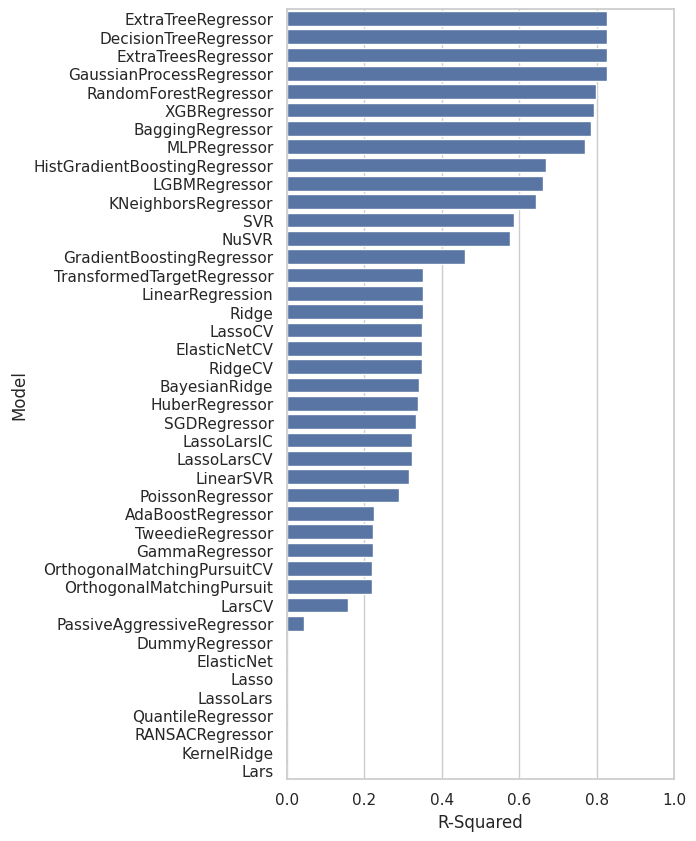

In [317]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

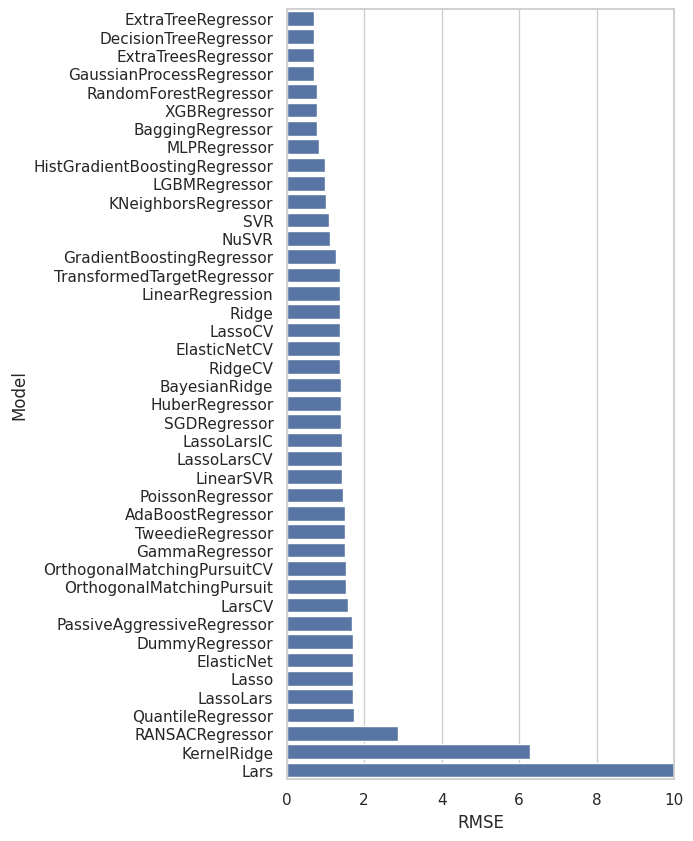

In [318]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))